In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
import datetime
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce', downcast='integer')
    
    tweet_dfs[i] = tweet_df

In [4]:
tweet_name_to_index = {}
for i in range(len(root_tweet_names)):
    tweet_name_to_index[root_tweet_names[i]] = i
# for key in tweet_name_to_index.keys():
#     print key

In [5]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [7]:
path = '../RetweetDataAOAS/Partition/'
partition_names = [f for f in listdir(path) if isfile(join(path, f))]
partitions = {}
# for i in range(len(partition_names)):
for i in range(1, 2):
    partitions[i] = {}
    print i
    partition_df = pd.read_excel(path+partition_names[i], encoding = "ISO-8859-1")
    for index, row in partition_df.iterrows():
        training_file_name = format_partition_file_name(row['Training'])
        prediction_file_name = format_partition_file_name(row['Prediction'])
        print "\n", training_file_name
        print prediction_file_name
        partitions[i][tweet_name_to_index[training_file_name]] = True
        partitions[i][tweet_name_to_index[prediction_file_name]] = False    

1

Source_followers_tweet_0022_Lawrence.txt
Source_followers_tweet_0024_pbsgwen.txt

Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0028_AnnCoulter.txt

Source_followers_tweet_0031_ASAPYams.txt
Source_followers_tweet_0031_CNET.txt

Source_followers_tweet_0037_EvaLongoria.txt
Source_followers_tweet_0044_JonnyBones.txt

Source_followers_tweet_0048_MissInfoTV.txt
Source_followers_tweet_0068_CharlesMBlow.txt

Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0070_E40.txt

Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0074_iamwill.txt

Source_followers_tweet_0085_MrChuckD.txt
Source_followers_tweet_0091_CharlesMBlow.txt

Source_followers_tweet_0092_AnnCoulter.txt
Source_followers_tweet_0092_jasonsegel.txt

Source_followers_tweet_0101_GarryShandling.txt
Source_followers_tweet_0101_Pitbull.txt

Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0107_djkhaled.txt

Source_followers_tweet_0108_newtgingrich.txt
Source_followers_twe

In [8]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

# modify the dfs accordingly
for i in range(len(root_tweet_names)):
    for index, row in tweet_dfs[i].iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_dfs[i].at[row['ParentDfIndex'],
                                                      'Time']
            tweet_dfs[i].loc[index,"ReactionTime"] = reaction_time
        else:
            tweet_dfs[i].loc[index,"ReactionTime"] = datetime.timedelta(seconds=0)

In [9]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet
        

In [10]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [11]:
def get_m_x_t(x,sec):
    return len(tweet_dfs[x].loc[tweet_dfs[x]["ReactionTime"] < datetime.timedelta(seconds=sec)])

In [45]:
# linear regression model setup

time_train = {} #key is time, value is a dictionary
retweets_train = {}
time_test = {}
retweets_test = {}

t = []
m_x_t = []
M_x = []

t_test = []
m_x_t_test = []
M_x_test = []


for i in range(1,14):
    secs = int(np.floor(np.exp(i)))
    for x in range(len(root_tweet_names)):
#     for x in range(10):
        total_retweets = len(tweet_dfs[x])-1
        if partitions[1][x]:
            t.append(i)
            m_x_t.append(get_m_x_t(x,secs))
            M_x.append(total_retweets)
        else:
            t_test.append(i)
            m_x_t_test.append(get_m_x_t(x,secs))
            M_x_test.append(total_retweets)
            

t = np.array(t)
M_x_log = np.log(np.array(M_x))
M_x_max = np.amax(M_x_log)
M_x_log = M_x_log/ M_x_max

m_x_t = np.array(m_x_t)
m_x_t_log = np.log(m_x_t)/M_x_max

m_x_t_test_log = np.log(np.array(m_x_t_test))/M_x_max
M_x_test_log = np.log(np.array(M_x_test))/M_x_max

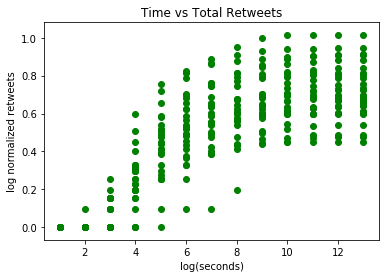

In [37]:
fig, ax = plt.subplots()
plt.scatter(t, m_x_t_test_log,  color='green')
# ax = fig.add_subplot(111)
# fig.subplots_adjust(top=0.85)
ax.set_title('Time vs Total Retweets')

ax.set_xlabel('log(seconds)')
ax.set_ylabel('log normalized retweets')

plt.show()

([], <a list of 0 Text yticklabel objects>)

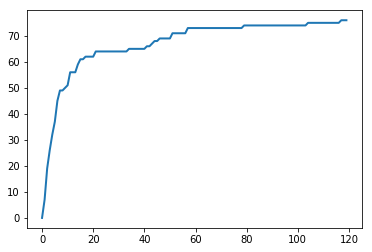

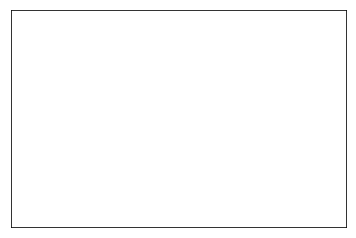

In [13]:
# example tweet

t1 = []
rt1 = []

for i in range(120):
    t1.append(i)
    rt1.append(get_m_x_t(1,i*60))
    
plt.plot(t1, rt1, label='line 1', linewidth=2)
fig, ax = plt.subplots()

plt.xticks(())
plt.yticks(())

In [142]:
# Szabo and Huberman: log(M^x) = beta(t) + log(m^x(t)) + e^x

with pm.Model() as regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_t = pm.Normal('beta_t', 0, sd=20, shape = (len(t),1))
        
    e_x = pm.Normal("e", 0, sd = 1, shape = (len(t),1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_t + m_x_t_log + e_x,
                        sd=sigma, observed=M_x_log)

In [43]:
# Run and fit our model
with regression_model:
#     step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, beta_t, sigma_log__]
100%|██████████| 2000/2000 [01:29<00:00, 22.42it/s]


In [46]:
# modified Szabo and Huberman: log(M^x) = beta_0 + beta_t*t + beta_m * log(m^x(t)) + e^x

with pm.Model() as regression_model_2:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', mu = 0, sd=20)
    beta_t = pm.Normal('beta_t', mu = 0, sd=20)
    beta_m = pm.Normal('beta_m', mu = 0, sd=20)
        
    e_x = pm.Normal("e", mu = 0, sd = 1, shape = (len(t),1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_0 + beta_t*t + beta_m*m_x_t_log + e_x,
                        sd=sigma, observed=M_x_log)

In [53]:
# Run and fit our model

# from scipy import optimize

with regression_model_2:
#     start = pm.find_MAP(fmin=optimize.fmin_powell)
    step = pm.Metropolis()
    trace = pm.sample(2000, tune=1000, chains=10, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [e, beta_m, beta_t, beta_0, sigma_log__]
100%|██████████| 3000/3000 [05:47<00:00,  8.63it/s]
The acceptance probability does not match the target. It is 0.902047429769, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0705356251639, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0723645576743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.901949894336, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diver

In [54]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,0.699645,0.041278,0.004114,0.638879,0.768661,5.0,4.846850
beta_t,-0.034870,0.000155,0.000008,-0.035180,-0.034602,47.0,1.091955
beta_m,0.545941,0.001891,0.000089,0.542461,0.549804,57.0,1.069448
e__0_0,-0.009077,0.041911,0.004144,-0.081475,0.054342,5.0,4.101143
e__1_0,-0.009035,0.041721,0.004123,-0.079497,0.056346,5.0,4.089186
e__2_0,-0.009225,0.041370,0.004089,-0.079208,0.056214,5.0,4.078732
e__3_0,-0.009484,0.042115,0.004165,-0.078543,0.056843,5.0,4.196053
e__4_0,-0.008403,0.042139,0.004166,-0.076575,0.062645,5.0,4.152528
e__5_0,-0.008285,0.043438,0.004296,-0.076185,0.064856,5.0,4.282456
e__6_0,-0.009003,0.042035,0.004156,-0.079381,0.059911,5.0,4.133162


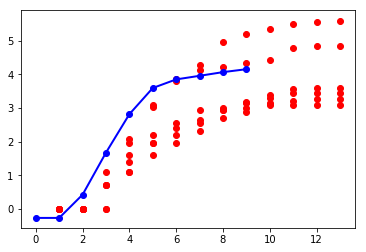

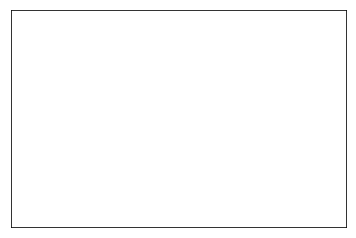

In [48]:
# Plot outputs

plt.scatter(t, m_x_t_log,  color='red')

b_t = np.mean(trace['beta_t'])
# b_1 = np.mean(trace['beta_1'])
x_line = [i for i in range(10)]
y_line = []
for val in x_line:
    y_line.append(b_t + m_x_t_log[6*val])

plt.plot(x_line, y_line, 'bo-', label='line 1', linewidth=2)
fig, ax = plt.subplots()

plt.xticks(())
plt.yticks(())

plt.show()

0.509556433765


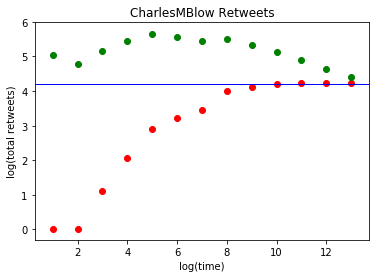

In [50]:
# plot a single retweet graph
# red is obsered
# blue is total retweeted
# green is prediction


j = 5

print M_x_log[j]

fig, ax = plt.subplots()
plt.scatter(t[j::26], m_x_t_test_log[j::26]*M_x_max,  color='red')
plt.axhline(y = M_x_test_log[j]*M_x_max, linewidth=1, color='blue')

pred = []
b_0 = np.mean(trace['beta_0'])
b_t = np.mean(trace['beta_t'])
b_m = np.mean(trace['beta_m'])

for i in range(1,14):
#     print i, 26*(i-1)+j
    pred.append(max(b_0 + b_t*i + b_m * m_x_t_test_log[26*(i-1)+j],m_x_t_test_log[26*(i-1)+j])*M_x_max )
#     pred.append((b_0 + b_t*i + b_m * m_x_t_test_log[26*(i-1)+j])*M_x_max )
    
# print t[j::26]
# print pred
    
plt.scatter(t[j::26], pred,  color='green')

ax.set_title('CharlesMBlow Retweets')

ax.set_xlabel('log(time)')
ax.set_ylabel('log(total retweets)')

plt.show()

0.699645358112
-0.0348702837541
0.545941221252


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1d5c66590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd1d4887890>]], dtype=object)

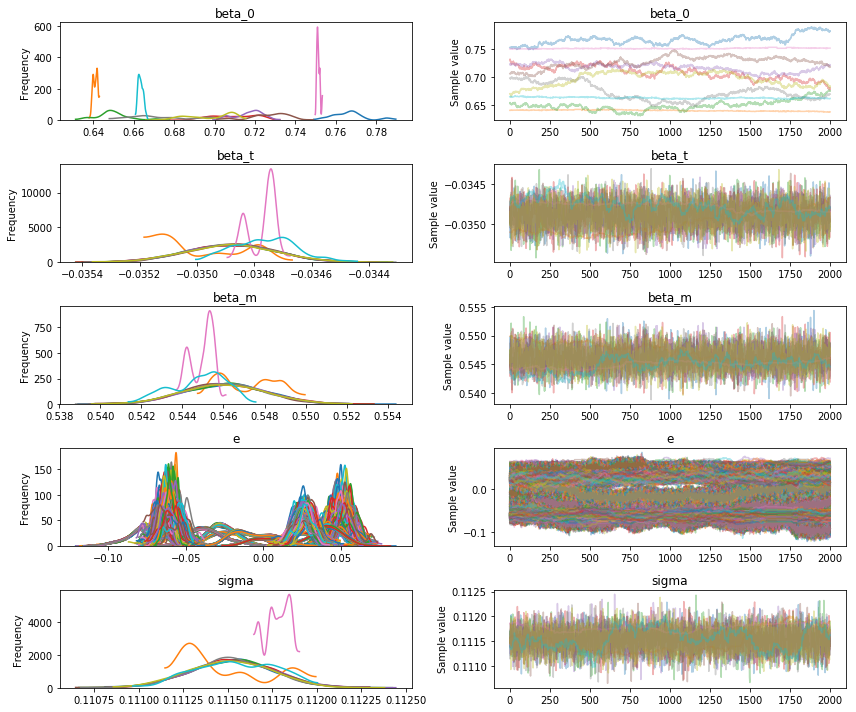

In [55]:
print np.mean(trace['beta_0'])
print np.mean(trace['beta_t'])
print np.mean(trace['beta_m'])
pm.traceplot(trace)

In [96]:
# APE

# beta_0 + beta_1 * followers_train_log

b_0_list = trace['beta_0'][0::50]
b_t_list = trace['beta_t'][0::50]
b_m_list = trace['beta_m'][0::50]

print len(b_0_list)

APE = {} #key is the ith prediction tweet, value is an array of APE indexed by time


A_t = np.array(M_x_test_log[:26])    
    
# m_x_t_test_log is input, every 13 entries represent a time step
for i in range(14):
    APE[i] = np.array([]) # array of APEs for percentage observed
    temp = np.array(m_x_t_test_log[i:i+26]) # for the time
    for j in range(len(temp)):
        pred = b_0_list + b_t_list*(i+1) + b_m_list*temp[j] # input is time, currently observed retweets
#         pred = np.maximum(pred, A_t[j])
#         print "\n", i,j,A_t[j], pred
        diff = np.absolute((A_t[j] - pred)/A_t[j])
#         print i,j,diff
#         print APE[i].shape, diff.shape
        APE[i] = np.concatenate([APE[i], diff])

print APE

# print m_x_t_test_log
# print M_x_test_log

# mape = 0
# for i in APE:
#     mape += APE[i]
# mape = mape / len(APE)
# print mape

400
{0: array([ 0.17725309,  0.17343529,  0.18217002, ...,  0.38037931,
        0.38093276,  0.38157185]), 1: array([ 0.12024793,  0.11599326,  0.12528346, ...,  0.41471424,
        0.41528993,  0.41587967]), 2: array([ 0.06324276,  0.05855123,  0.06839689, ...,  0.44904918,
        0.4496471 ,  0.45018749]), 3: array([ 0.00623759,  0.00110921,  0.01151033, ...,  0.48338411,
        0.48400427,  0.48449531]), 4: array([ 0.05076757,  0.05633282,  0.04537624, ...,  0.51771905,
        0.51836144,  0.51880314]), 5: array([ 0.10777274,  0.11377485,  0.1022628 , ...,  0.55205398,
        0.55271861,  0.55311096]), 6: array([ 0.16477791,  0.17121688,  0.15914937, ...,  0.58638892,
        0.58707578,  0.58741878]), 7: array([ 0.22178307,  0.22865891,  0.21603593, ...,  0.62072385,
        0.62143296,  0.6217266 ]), 8: array([ 0.27878824,  0.28610094,  0.2729225 , ...,  0.65505878,
        0.65579013,  0.65603442]), 9: array([ 0.33579341,  0.34354296,  0.32980906, ...,  0.68939372,
        0.

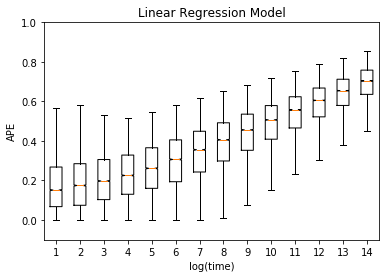

In [97]:
fig, ax = plt.subplots()

plt.boxplot([APE[i] for i in APE],1, '')

ax.set_title('Linear Regression Model')

ax.set_xlabel('log(time)')
ax.set_ylabel('APE')
plt.ylim((-0.1,1))
plt.show()

In [129]:
# modified logistic regression model? 
with pm.Model() as logistic_regression:
#     x_0 = pm.Normal('x_0', 0, sd=2)
    x_t = pm.Normal('x_t', 0, sd=2)
    x_m = pm.Normal('x_m', 0, sd=2)
    
    beta_t = pm.Normal('beta_t', 1, sd=5)
    beta_m = pm.Normal('beta_m', 1, sd=5)
#     beta_l = pm.Normal('beta_l', 1, sd=5)
    
#     beta_t = pm.HalfNormal('beta_t', sd=20)
#     beta_m = pm.HalfNormal('beta_m', sd=2)
#     beta_l = pm.HalfNormal('beta_l', sd=20)
    
#     e_x = pm.Normal("e", mu = 0, sd = 1, shape = (len(t),1))
    
    # linreg model
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', mu = 0, sd=20)
    beta_t_l = pm.Normal('beta_t_l', mu = 0, sd=20)
    beta_m_l = pm.Normal('beta_m_l', mu = 0, sd=20)
        
    e_x = pm.Normal("e_x", mu = 0, sd = 1, shape = (len(t),1))

    # Define likelihood    
    
    # model what percentage of top tweet we'll get
    top = pm.Normal('top', mu=beta_0 + beta_t_l*t + beta_m_l*m_x_t_log + e_x,
                        sd=sigma, observed=M_x_log)
    
    mu = pm.Deterministic('mu', top/(1+np.exp(-1*(beta_t*(t-x_t) + beta_m*(m_x_t_log-x_m)))))  #e_x
    
    likelihood = pm.Bernoulli('y', mu, observed=M_x_log) # 
#     likelihood = pm.Bernoulli('y', beta_l*pm.math.sigmoid(x_0))
    
#     WTP=pm.Deterministic('WTP',-x_0/beta_m)

In [130]:
# Run and fit our model
with logistic_regression:
#     step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=4) #  init='advi+adapt_diag'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e_x, beta_m_l, beta_t_l, beta_0, sigma_log__, beta_m, beta_t, x_m, x_t]
100%|██████████| 2000/2000 [06:51<00:00,  4.86it/s]
The acceptance probability does not match the target. It is 0.91788920245, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [131]:
for RV in logistic_regression.basic_RVs:
    print(RV.name, RV.logp(logistic_regression.test_point))

('x_t', array(-1.612085713764618))
('x_m', array(-1.612085713764618))
('beta_t', array(-2.528376445638773))
('beta_m', array(-2.528376445638773))
('sigma_log__', array(-2.7641181592074506))
('beta_0', array(-3.9146708067586635))
('beta_t_l', array(-3.9146708067586635))
('beta_m_l', array(-3.9146708067586635))
('e_x', array(-310.60122422317903))
('top', array(-133363.3769587348))
('y', array(-380.0486059994799))


In [138]:
# print np.mean(trace['beta_l'])
print np.mean(trace['beta_t'])
print np.mean(trace['beta_m'])
print np.mean(trace['x_t'])
print np.mean(trace['x_m'])
print np.mean(trace['top'])
pm.traceplot(trace)

-0.538728424907
7.86828722338
-0.161876595846
0.464625233539


KeyError: 'Unknown variable top'

0.597883871415


KeyError: 'Unknown variable top'

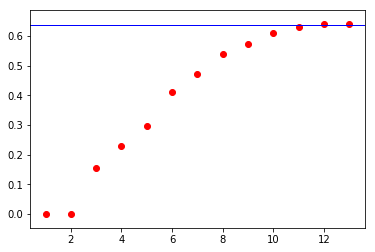

In [137]:
# plot a single retweet graph
# red is obsered
# blue is total retweeted
# green is prediction


j = 7

print M_x_log[j]

plt.scatter(t[j::26], m_x_t_test_log[j::26],  color='red')
plt.axhline(y = M_x_test_log[j], linewidth=1, color='blue')

pred = []
b_l = np.mean(trace['top'])
b_t = np.mean(trace['beta_t'])
b_m = np.mean(trace['beta_m'])

print x_0, b_l, b_t, b_m

for i in range(1,14):
#     print i, 26*(i-1)+j
    pred.append(b_l/(1+np.exp(-0.1*(2*(i+3) - 0.2*(m_x_t_test_log[26*(i-1)+j] + 3)) )) )
    
# print t[j::26]
# print pred
    
plt.scatter(t[j::26], pred,  color='green')

plt.show()